<a href="https://colab.research.google.com/github/kauanunnes/visao-computacional-pjbl/blob/main/pjbl_visao_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/MyDrive/archives/train'
test_dir = '/content/drive/MyDrive/archives/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # primeiro congela o modelo

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3928 - loss: 1.2428 - val_accuracy: 0.5957 - val_loss: 0.8350 - learning_rate: 5.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 684ms/step - accuracy: 0.5861 - loss: 0.8639 - val_accuracy: 0.6312 - val_loss: 0.8085 - learning_rate: 5.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 698ms/step - accuracy: 0.6646 - loss: 0.7641 - val_accuracy: 0.7163 - val_loss: 0.6778 - learning_rate: 5.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step - accuracy: 0.6837 - loss: 0.6417 - val_accuracy: 0.7376 - val_loss: 0.6558 - learning_rate: 5.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 707ms/step - accuracy: 0.7141 - loss: 0.6726 - val_accuracy: 0.7305 - val_loss: 0.6616 - learning_rate: 5.0000e-04
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 692ms/step - accuracy: 0.7784 - loss: 0.5333 - val_accuracy: 0.7447 - val_loss: 0.6173 - learning_rate: 5.0000e-04
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 718ms/step - accura

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 40  # descongela últimas 40 camadas

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7235 - loss: 0.6701 - val_accuracy: 0.7660 - val_loss: 0.5740 - learning_rate: 1.0000e-05
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 687ms/step - accuracy: 0.7225 - loss: 0.6583 - val_accuracy: 0.7305 - val_loss: 0.5760 - learning_rate: 1.0000e-05
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 704ms/step - accuracy: 0.7412 - loss: 0.6366 - val_accuracy: 0.7518 - val_loss: 0.5797 - learning_rate: 1.0000e-05
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 700ms/step - accuracy: 0.8042 - loss: 0.4826 - val_accuracy: 0.7730 - val_loss: 0.5368 - learning_rate: 1.0000e-05
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 707ms/step - accuracy: 0.7354 - loss: 0.6130 - val_accuracy: 0.7872 - val_loss: 0.5617 - learning_rate: 1.0000e-05
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 790ms/step - accuracy: 0.7934 - loss: 0.5128 - val_accuracy: 0.8014 - val_loss: 0.5624 - learning_rate: 1.0000e-05
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 696ms/step - accura

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Acurácia no conjunto de teste: {test_acc*100:.2f}%")

Found 114 images belonging to 3 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7928 - loss: 0.4874

✅ Acurácia no conjunto de teste: 76.32%


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Relatório de Classificação:

              precision    recall  f1-score   support

      adidas       0.69      0.82      0.75        38
    converse       0.79      0.89      0.84        38
        nike       0.85      0.58      0.69        38

    accuracy                           0.76       114
   macro avg       0.78      0.76      0.76       114
weighted avg       0.78      0.76      0.76       114



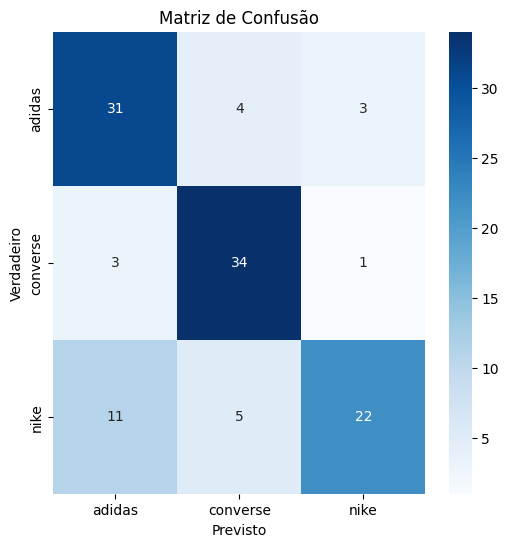

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\nRelatório de Classificação:\n')
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Matriz de Confusão")
plt.ylabel("Verdadeiro")
plt.xlabel("Previsto")
plt.show()

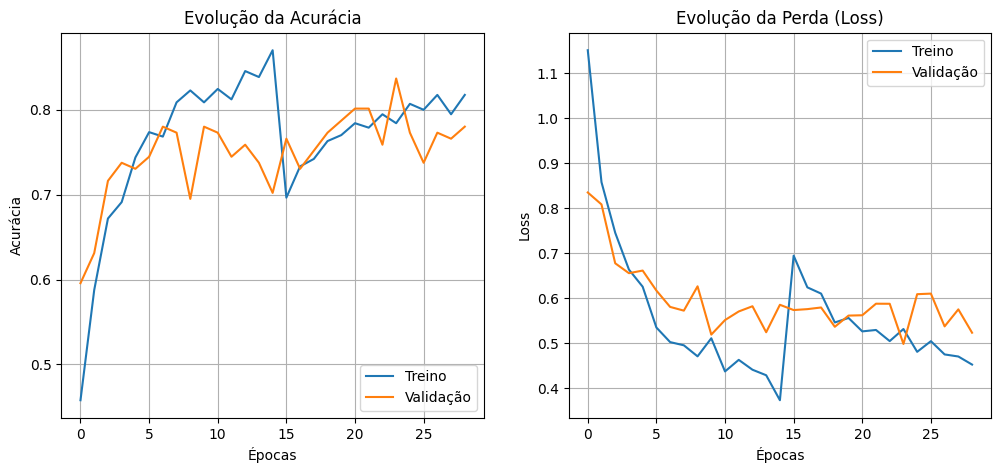

In [ ]:
# ============================================
# 📈 GRÁFICOS DE APRENDIZADO (ACURÁCIA E PERDA)
# ============================================

# Junta histórico do treinamento inicial + fine-tuning
acc = history.history['accuracy'] + fine_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_history.history['val_accuracy']
loss = history.history['loss'] + fine_history.history['loss']
val_loss = history.history['val_loss'] + fine_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# --- Acurácia ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.grid(True)

# --- Perda ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()
